#### COVID-19 Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import geopy
import math

import sklearn as sk

from datetime import datetime

In [2]:
full_data = pd.read_csv("../data/full_data_mar_18.csv")
full_data = full_data.fillna(0)
full_data.head()

,date,location,new_cases,new_deaths,total_cases,total_deaths
0,2020-02-25,Afghanistan,0.0,0.0,1,0.0
1,2020-02-26,Afghanistan,0.0,0.0,1,0.0
2,2020-02-27,Afghanistan,0.0,0.0,1,0.0
3,2020-02-28,Afghanistan,0.0,0.0,1,0.0
4,2020-02-29,Afghanistan,0.0,0.0,1,0.0


#### Filter Data for Sri Lanka

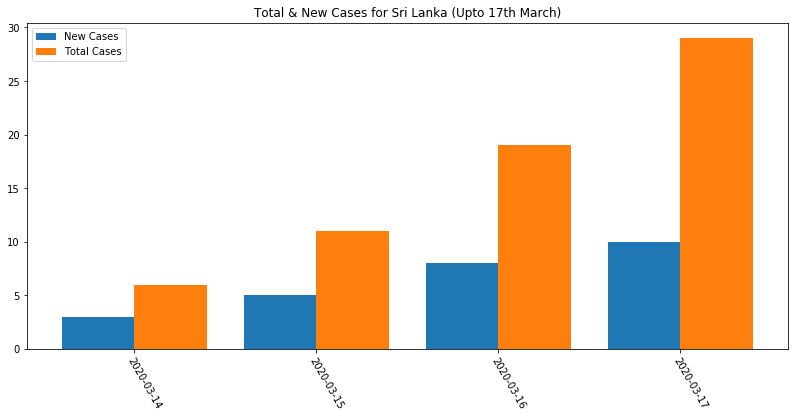

In [3]:
sl_data = full_data[(full_data['location'] == "Sri Lanka") & (full_data['total_cases'] > 5)]
f = plt.figure(figsize=(30,6))
ax = f.add_subplot(121)
width = 0.4
x_ind = np.arange(len(sl_data['date']))
ax.set_xticks(x_ind + width / 2)
ax.set_xticklabels(sl_data['date'], rotation=-60, ha='left', rotation_mode='anchor')
ax.set_title("Total & New Cases for Sri Lanka (Upto 17th March)")
ax.bar(x_ind, 'new_cases', width, data = sl_data, label = "New Cases")
ax.bar(x_ind + width, 'total_cases', width, data = sl_data, label = "Total Cases")
ax.legend()
plt.show()

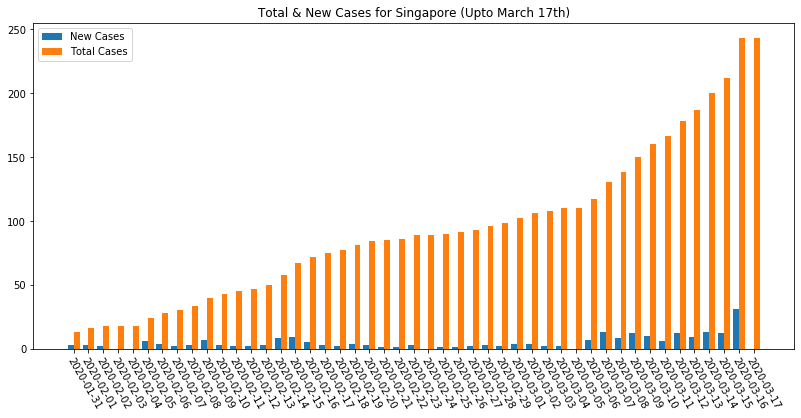

In [4]:
sg_data = full_data[(full_data['location'] == "Singapore") & (full_data['total_cases'] > 10)]
f = plt.figure(figsize=(30,6))
ax = f.add_subplot(121)
width = 0.4
x_ind = np.arange(len(sg_data['date']))
ax.set_xticks(x_ind + width / 2)
ax.set_xticklabels(sg_data['date'], rotation=-60, ha='left', rotation_mode='anchor')
ax.set_title("Total & New Cases for Singapore (Upto March 17th)")

ax.bar(x_ind, 'new_cases', width, data = sg_data, label = "New Cases")
ax.bar(x_ind + width, 'total_cases', width, data = sg_data, label = "Total Cases")
ax.legend()
plt.show()

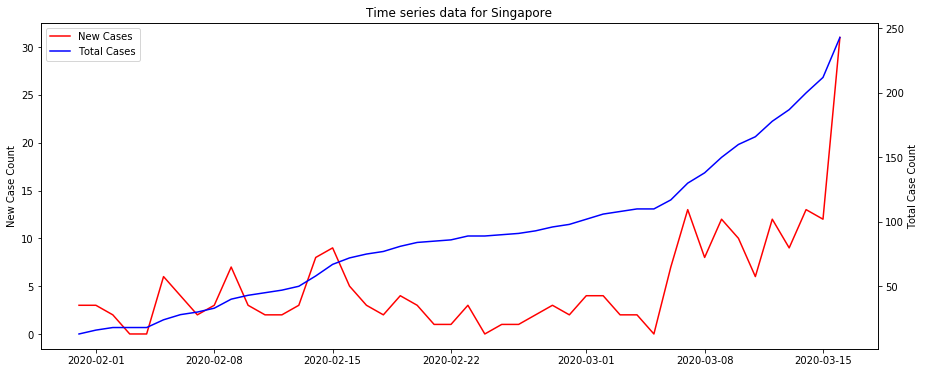

In [5]:
ts_sg_data = sg_data.copy()
ts_sg_data['new_cases'] = ts_sg_data['new_cases'].astype(int)
ts_sg_data['date'] = pd.to_datetime(ts_sg_data['date'])
ts_sg_data.set_index('date', inplace=True)
ts_sg_data = ts_sg_data.loc['2020-01-31':'2020-03-16'].asfreq('D')

fig, ax1 = plt.subplots(figsize=(15,6))
ax2 = ax1.twinx()

ln1 = ax1.plot(ts_sg_data['new_cases'], color = 'r', label = "New Cases")
ln2 = ax2.plot(ts_sg_data['total_cases'], color = 'b', label = "Total Cases")

lns = ln1 + ln2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=2)

ax1.set_ylabel("New Case Count")
ax2.set_ylabel("Total Case Count")
plt.title("Time series data for Singapore")
plt.show()

In [6]:
import itertools
import statsmodels.api as sm
from pylab import rcParams
from statsmodels.tsa.stattools import adfuller

def check_ts_stationarity(ts_data, w_size):
    rolmean = ts_data.rolling(w_size).mean()
    rolstd = ts_data.rolling(w_size).std()
    plt.figure(figsize=(15,6))
    plt.plot(ts_data, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation (New Cases - Singapore)')
    plt.show()
    
    decomposition = sm.tsa.seasonal_decompose(ts_data, model='additive')
    fig = decomposition.plot()
    fig.set_size_inches(12,15)
    axes = fig.get_axes()
    for ax in axes:
        ax.set_xticks(ts_data.index)
        ax.set_xticklabels(ts_data.index.date, rotation=-60, rotation_mode='anchor', ha='left')
    fig.tight_layout(pad=2.0)
    plt.show()

    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(ts_data, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

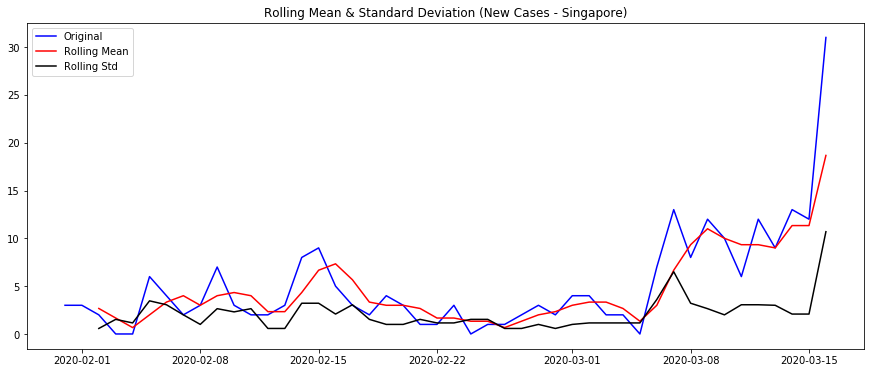

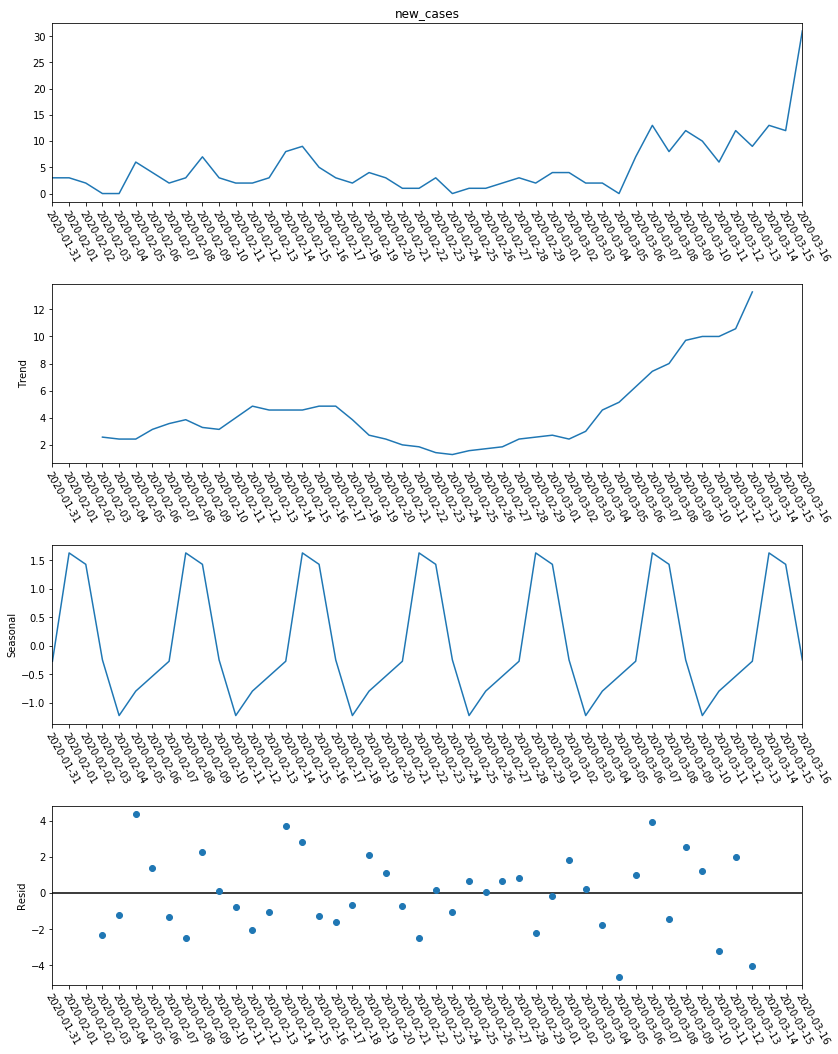

Results of Dickey-Fuller Test:
Test Statistic                  0.522905
p-value                         0.985553
#Lags Used                      1.000000
Number of Observations Used    44.000000
Critical Value (1%)            -3.588573
Critical Value (5%)            -2.929886
Critical Value (10%)           -2.603185
dtype: float64


In [7]:
ts_sg = ts_sg_data['new_cases']
check_ts_stationarity(ts_sg, 3)

In [8]:
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.api import acf, pacf, graphics

sel = ar_select_order(ts_sg, 14, glob=True)
sel.ar_lags
res_ar = sel.model.fit()
res_ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:              new_cases   No. Observations:                   46
Model:             Restr. AutoReg(11)   Log Likelihood                 -97.313
Method:               Conditional MLE   S.D. of innovations              3.902
Date:                Sat, 21 Mar 2020   AIC                              3.009
Time:                        01:14:13   BIC                              3.231
Sample:                    02-11-2020   HQIC                             3.085
                         - 03-16-2020                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
intercept         2.4405      1.587      1.537      0.124      -0.671       5.552
new_cases.L2      0.7115      0.185      3.855      0.000       0.350       1.073
new_cases.L6      0.5871      0.215      2.736      0.006       0.167       1.008
new_cases.L11    -0.8761      0.319     -2.744      0.006      -1.502      -0.250
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1            -0.8732           -0.0000j            0.8732           -0.5000
AR.2            -0.9082           -0.5348j            1.0540           -0.4153
AR.3            -0.9082           +0.5348j            1.0540            0.4153
AR.4            -0.4847           -0.8933j            1.0163           -0.3291
AR.5            -0.4847           +0.8933j            1.0163            0.3291
AR.6             0.9535           -0.1504j            0.9652           -0.0249
AR.7             0.9535           +0.1504j            0.9652            0.0249
AR.8             0.6676           -0.7472j            1.0020           -0.1339
AR.9             0.6676           +0.7472j            1.0020            0.1339
AR.10            0.2084           -1.0836j            1.1035           -0.2198
AR.11            0.2084           +1.0836j            1.1035            0.2198
------------------------------------------------------------------------------
"""

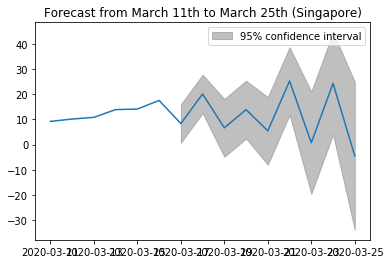

In [9]:
fig = res_ar.plot_predict(40, 54)
plt.title("Forecast from March 11th to March 25th (Singapore)")
plt.show()

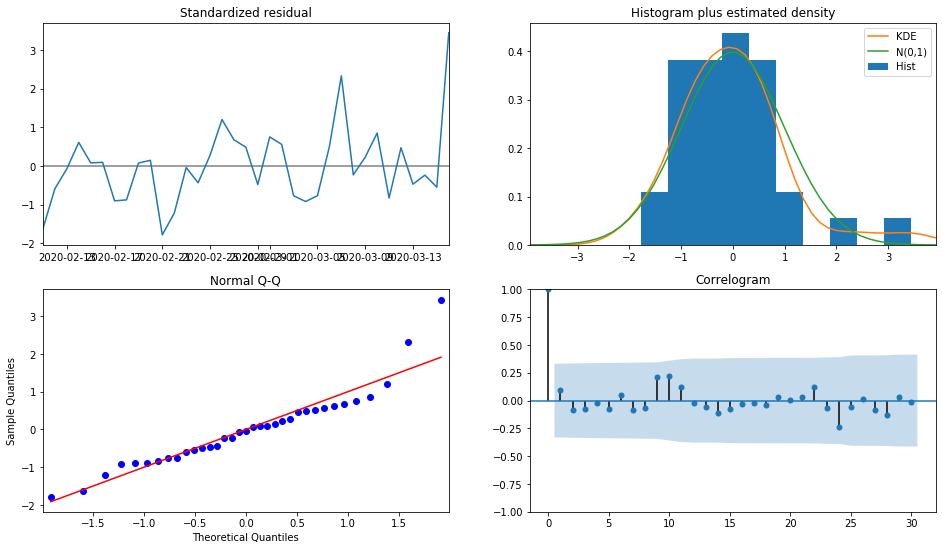

In [10]:
fig = plt.figure(figsize=(16,9))
fig = res_ar.plot_diagnostics(fig=fig, lags=30)

In [11]:
fcast = res_ar.predict(start=40, end=54, dynamic=True)
round(fcast).astype(int)

2020-03-11     9
2020-03-12    10
2020-03-13    13
2020-03-14    13
2020-03-15    17
2020-03-16    17
2020-03-17    14
2020-03-18     9
2020-03-19    13
2020-03-20     6
2020-03-21    13
2020-03-22     9
2020-03-23    11
2020-03-24     3
2020-03-25     7
Freq: D, dtype: int64

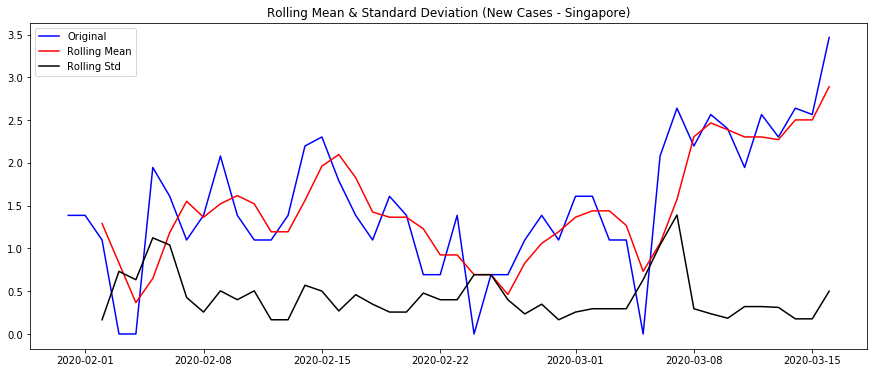

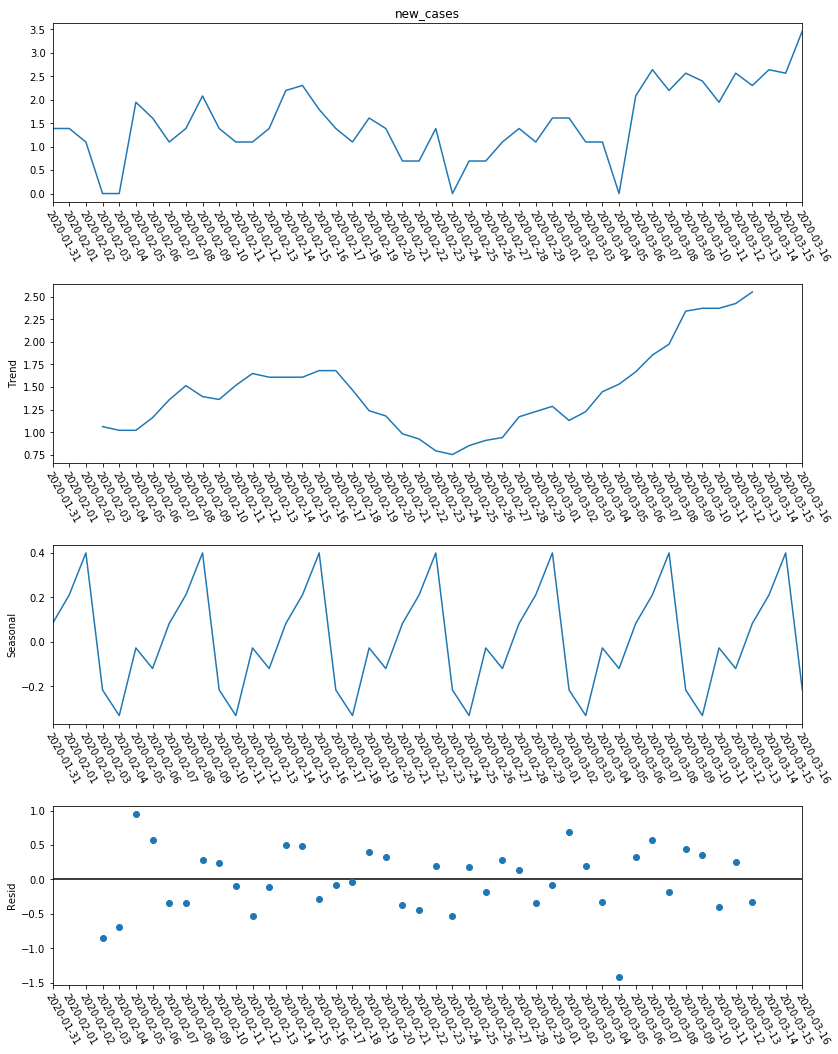

Results of Dickey-Fuller Test:
Test Statistic                 -2.634449
p-value                         0.086084
#Lags Used                      0.000000
Number of Observations Used    45.000000
Critical Value (1%)            -3.584829
Critical Value (5%)            -2.928299
Critical Value (10%)           -2.602344
dtype: float64


In [92]:
ts_sg_log = np.log(ts_sg_data['new_cases'] + 1)
check_ts_stationarity(ts_sg_log,3)

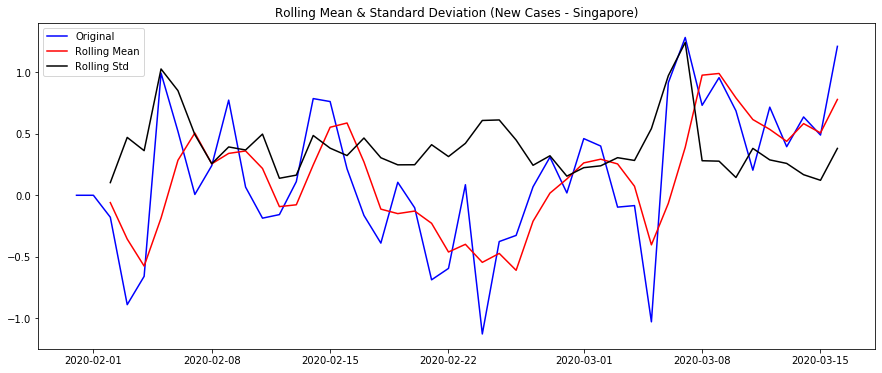

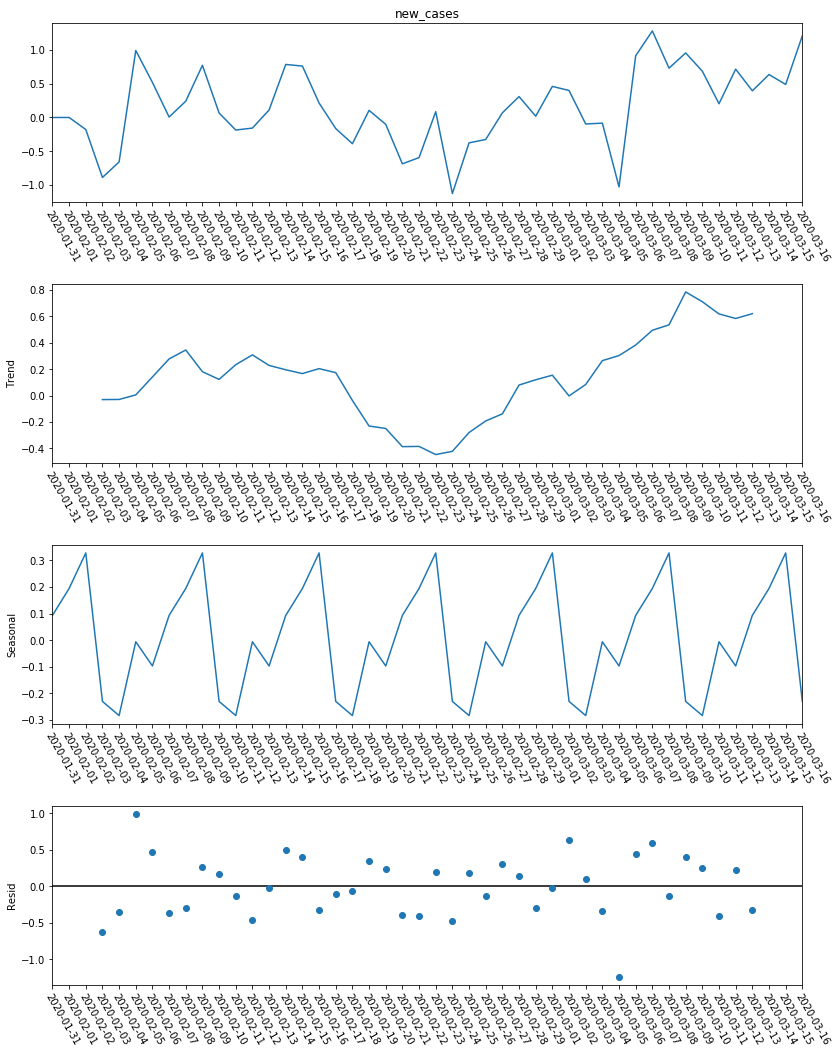

Results of Dickey-Fuller Test:
Test Statistic                 -3.838697
p-value                         0.002535
#Lags Used                      0.000000
Number of Observations Used    45.000000
Critical Value (1%)            -3.584829
Critical Value (5%)            -2.928299
Critical Value (10%)           -2.602344
dtype: float64


In [95]:
rolling_mean_exp_decay = ts_sg_log.ewm(halflife=5).mean()
ts_sg_log_exp_decay = ts_sg_log - rolling_mean_exp_decay
ts_sg_log_exp_decay.dropna(inplace=True)
check_ts_stationarity(ts_sg_log_exp_decay,3)

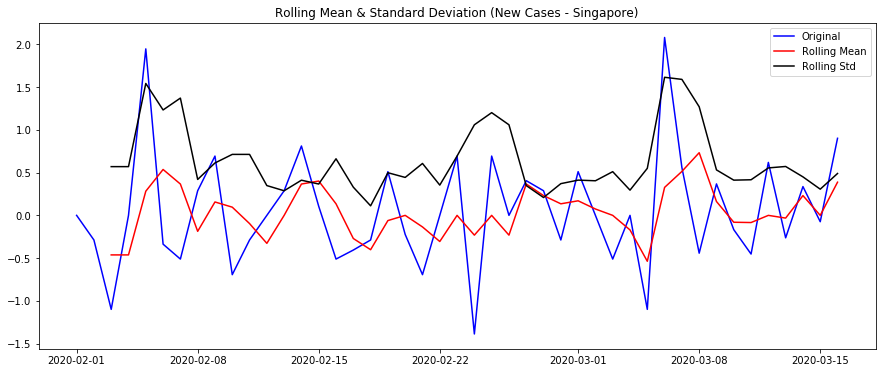

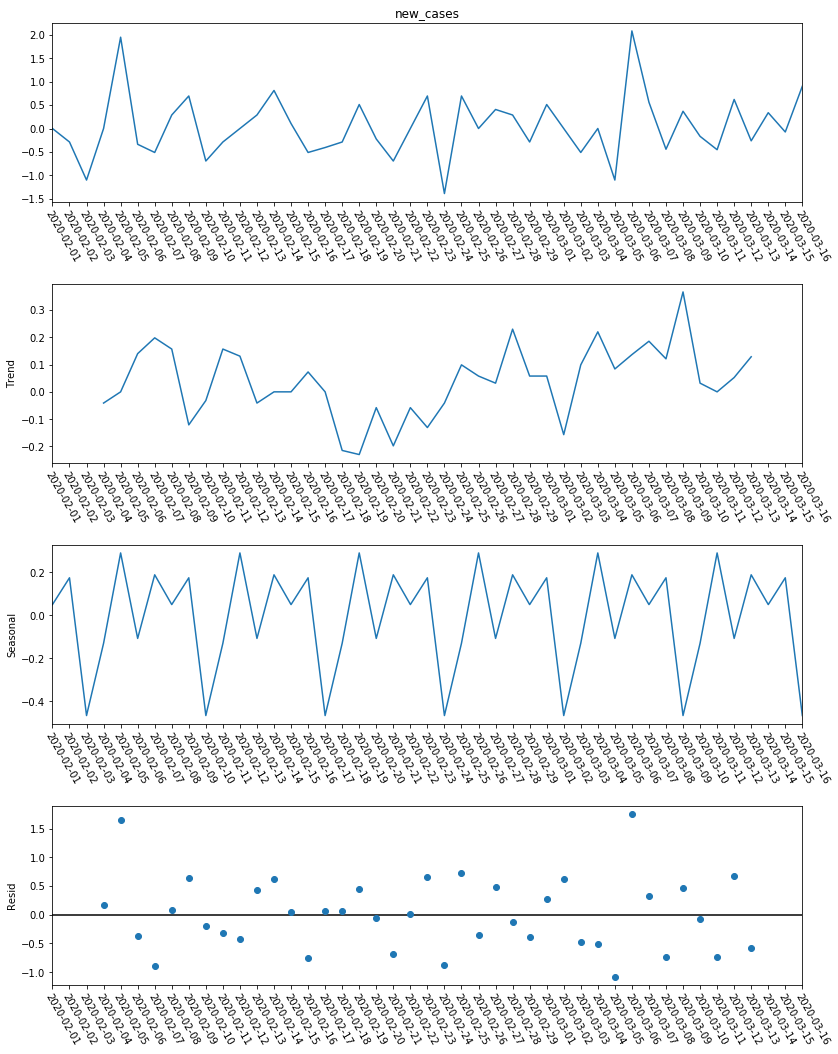

Results of Dickey-Fuller Test:
Test Statistic                -7.900576e+00
p-value                        4.195905e-12
#Lags Used                     0.000000e+00
Number of Observations Used    4.400000e+01
Critical Value (1%)           -3.588573e+00
Critical Value (5%)           -2.929886e+00
Critical Value (10%)          -2.603185e+00
dtype: float64


In [96]:
ts_sg_log_shift = ts_sg_log - ts_sg_log.shift()
ts_sg_log_shift.dropna(inplace=True)

check_ts_stationarity(ts_sg_log_shift, 3)

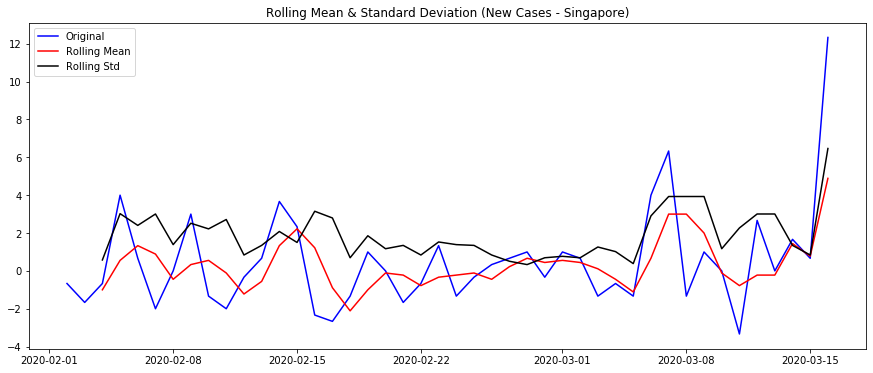

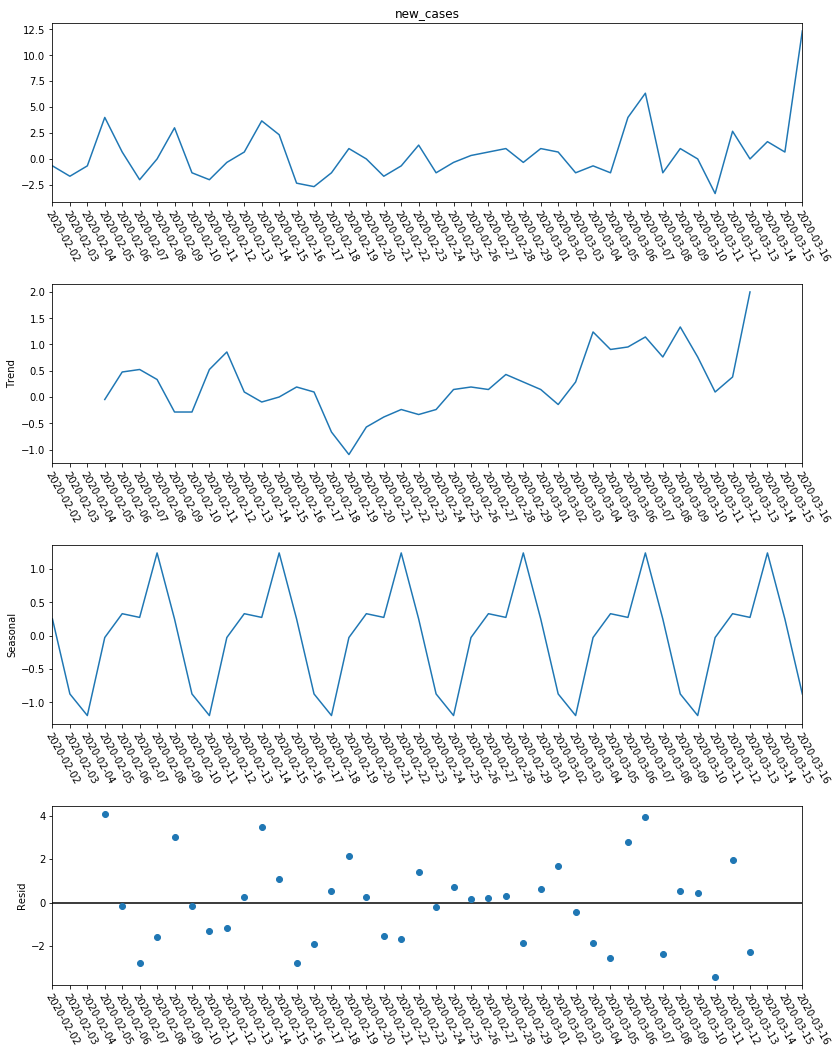

Results of Dickey-Fuller Test:
Test Statistic                 -4.139796
p-value                         0.000832
#Lags Used                      0.000000
Number of Observations Used    43.000000
Critical Value (1%)            -3.592504
Critical Value (5%)            -2.931550
Critical Value (10%)           -2.604066
dtype: float64


In [128]:
rolling_mean_ts = ts_sg.rolling(3).mean()
ts_sg_diff = ts_sg - rolling_mean_ts
ts_sg_diff.dropna(inplace=True)
check_ts_stationarity(ts_sg_diff,3)

In [129]:
prediction_ts = ts_sg_diff

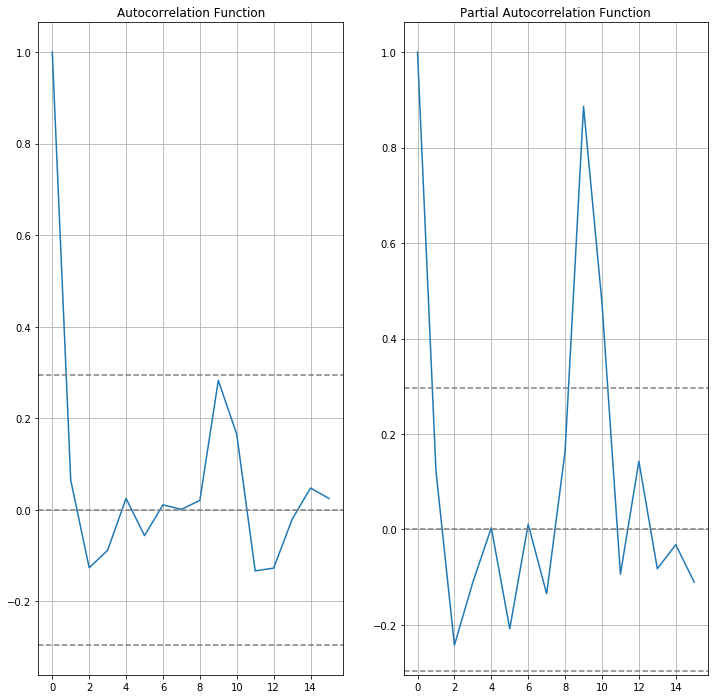

In [132]:
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(prediction_ts, nlags=15, fft=False)
lag_pacf = pacf(prediction_ts, nlags=15, method='ols')

plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(prediction_ts)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(prediction_ts)),linestyle='--',color='gray')
plt.grid()
plt.title("Autocorrelation Function")

plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(prediction_ts)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(prediction_ts)),linestyle='--',color='gray')
plt.grid()
plt.title("Partial Autocorrelation Function")
plt.show()

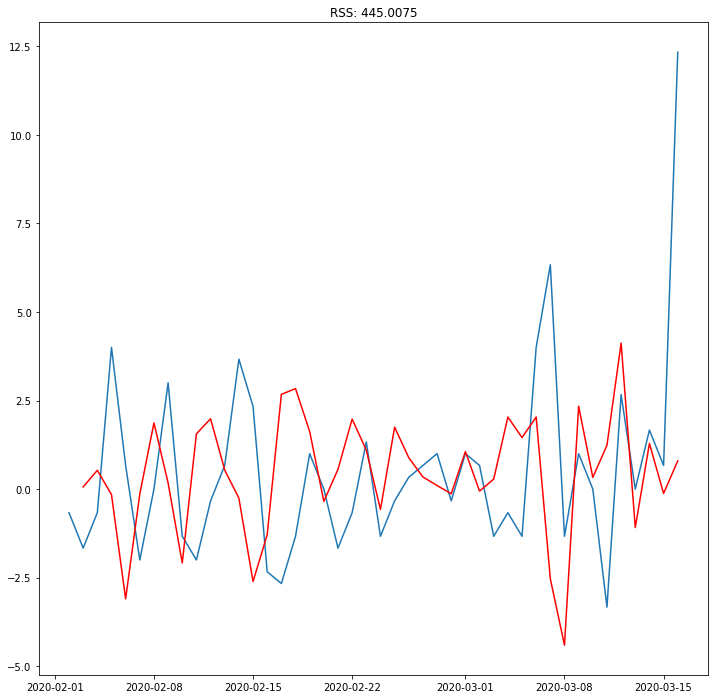

In [139]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(prediction_ts, order=(1,1,1))
res_ARIMA = model.fit(disp=-1)
plt.plot(prediction_ts)
plt.plot(res_ARIMA.fittedvalues, color='red')
plt.title("RSS: %.4f" % sum(((res_ARIMA.fittedvalues - prediction_ts)**2).dropna()))
plt.show()